In [3]:
import random
import numpy as np
import time

import math
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
%matplotlib inline

import itertools

In [4]:

def get_boltzmann(dE, T=300, kb=1.9872e-3):
  """
  This function determines the probability of accepting or rejecting a move according to a Boltzmann distribution.
   Arguments:
    - dE = Difference in energy between the previous and trial state.
    - T = Temperature in Kelvin
    - kb = Boltzmann's constant in Kcal/(mol*K)
  """
  beta = 1/(kb*T) #Thermodynamic beta
  boltz = np.exp(-beta*dE)
  return boltz


def get_boltzmann_exchange(dE, T1, T2, kb=1.9872e-3):
  beta1 = 1/(kb*T1)
  beta2 = 1/(kb*T2)
  boltz = np.exp(dE*(beta1-beta2))
  return boltz

def get_N_particles(N,parameters,dims=3):
  """
  makes a box of N particles one at a time in dims dimentions.
  """
  coords=[]
  coord=[]
  while len(coords)<N:              #Check to make sure the box is full.
    coord=[]
    for i in range(dims):           #get one particle
      coord.append(random.uniform(parameters['maxs'][i], parameters['mins'][i]))
    accept = box_builder(coord, coords,diameter=parameters['diameter'],bounds=parameters['bounds'])  #accept is either True or False
    if accept:                      #accpets the new point if it is not overlapping with an existing point.
      coords.append(coord)
  coords=np.array(coords)
  return coords

def box_builder(point,coords,diameter=0.0,bounds=[[-10,10],[-10,10],[-10,10]]):
  """
  Check the distance between the new particle and all particle already in the box.
  Arguments:
    - point = new point to potentially be added to the box. list of len dims.
    - coords = all points already in the box. List
    - diameter = minimum distance between particles. If diameter is 0 all points are accepted.
    - bounds = bounds of the box. Used to calculate distance between new particle and "virtual" particles

  """
  for i in range(len(coords)):          #iterate over all particles currently in box
    dist=0                              #distance between points. initalized at 0.
    for k in range(len(coords[i])):     #itterate over dimentions.
      n=abs(coords[i][k]-point[k])      #This distance is used for "real" particles within the box.
      if n>sum(abs(np.array(bounds[k])))/2.0:
        a=abs(min(coords[i][k],point[k])-min(bounds[k]))
        b=abs(max(bounds[k])-max(coords[i][k],point[k]))
        n=a+b                           #This distance is used for "virtual" particles outside the box.
      dist+=n**2
    if dist<diameter:                   #Chech is the particles are overlapping. If so, reject the point.
      return False
  return True


def get_distancesPB(coords,bounds=[[-10,10],[-10,10],[-10,10]]):
  """
  Get the distance between all particles.
  Arguments:
   - coords = list of particals. 
   - bounds = max and min points of the box in each dimention.
  """
  rs=[]
  for i in range(len(coords)):              #itterate over all particles
    for j in range(i+1,len(coords)):        #itterate over all particle, but don't double count any pairs
      dist=0                                #distance between points. initalized at 0.
      for k in range(len(coords[i])):
        n=abs(coords[i][k]-coords[j][k])    #This distance is used for "real" particles within the box.
        if n>sum(abs(np.array(bounds[k])))/2.0:
          a=abs(min(coords[i][k],coords[j][k])-min(bounds[k]))
          b=abs(max(bounds[k])-max(coords[i][k],coords[j][k]))
          n=a+b                             #This distance is used for "virtul" particles outside the box.
        dist+=n**2
      rs.append(dist**(1/2))
  return np.array(rs)



def get_hard_sphere(coords,parameters):           #Hard sphere potential.
  V=0
  rs=get_distancesPB(coords,parameters['bounds'])
  if not np.all(rs>=parameters['diameter']):
    V=math.inf
  return V

def get_LJ_N(coords, parameters):
  rs=get_distancesPB(coords,bounds=parameters['bounds'])        #Get all distances between particals
  V=0.0                                                         #initalize potential to 0
  for r in rs:                                                  #Loop over all distances
    if r<parameters['cutoff']:                                  #check if the distance is greater than the cutoff
      V+=4*parameters['epsilon']*((parameters['sigma']/r)**12-(parameters['sigma']/r)**6)   #Compute LJ potential
  return V


def get_potentialN(coords,params):                #intermediate potential function. Used to make switching potentials easier when I want to add a new one.
  V=0
  if params['potential']=='LJ':
    V=get_LJ_N(coords,parameters)                 #Get Lenard Jones potential
  if params['potential']=='HS':                   #Get Hard Sphere potential
    V=get_hard_sphere(coords,params)
  return V



def check_bounds(r_t,rmax=10.0, rmin=0.0):
  """
  Checks that a particle is within the bounds for a dimention.
  Arguments:
    - r_t = position of particle
    - rmax = maximum value allowed for r_t
    - rmin = minimum value allowed for r_t
  """
  step=rmax-rmin  #How much to move particle if it is outside of the bounds
  while r_t<=rmin or r_t>rmax:    #Check if particle is within the bounds.
    if r_t<=rmin:                 #If particle is too far left, loop it around to the right
      r_t+=step
    elif r_t>rmax:                #If particle is too far right, loop it around to the left
      r_t-=step
  return r_t                      #return the "fixed" value of r_t. If r_t was already within the bounds it is unchanged.


def get_move(step_size):
  """
  Determine how far to move a particle in each dimention.
  Arguments:
    - step_size = list of lenght dims with the maximum step size allowed in each dimention.
  """
  moves=[]
  for i in step_size:       #Loop over dimensions
    moves.append(random.uniform(-step_size[i], step_size[i]))
  return moves

def decide(V_t,V,coords_t,coords,T=300):
  """
  Decide to accept or reject an MC step.
  Arguments:
    - V_t = V trial. energy of proposed set of coodinates coords_t
    - V = Energy of previous set of coordinates coords
    - coords_t = coordinates of particles after proposed step
    - coords = coordinates of particles before proposed move
  """
  accept=0                      #accept or reject function. Initialized to reject
  if V_t < V:                   #If V_t<V, accept the move
    coords=coords_t
    V = V_t
    accept+=1
  else:                         #Determine chance to accept move based on boltzman distribution
    n=random.uniform(0,1)
    dE = V_t - V                #Delta E between previous step and proposed step.
    bolt=get_boltzmann(dE,T=T)  #Chance to accept move
    if n <= bolt:
      coords=coords_t
      V = V_t
      accept+=1
  #Return the coordinates, energy, and acceptance of the proposed step.
  #If accept==0 then V and coords are unchanged.
  return coords, V, accept      

def decide_exchange(V1,V2,coords1,coords2,T1,T2):
  """
  Decide to accept or reject an MC replica exchange.
  Arguments:
    - V1 = Energy of coords1
    - V2 = Energy of coords2
    - coords1 and coords2 = coordinates of particles that an exchange will be attempted on.
    - T1 and T2 = temperatures that the two replicas are being run with.
  """
  switch=0              #accept or reject an exchange. initialized to reject.
  n=random.uniform(0,1)
  dE = V1 - V2          #delta E between the replicas
  boltz=get_boltzmann_exchange(dE, T1, T2, kb=1.9872e-3)    #boltzman calculated with to temperaures to determine the probability of accepting an exchange
  if n <= boltz:
    switch+=1
    return V2, V1, coords2, coords1, switch
  else:
    return V1, V2, coords1, coords2, switch

  
def do_MC_exchange(energies,coords,Ts):
  """
  Perform replica exchange.
  Arguments:
    - energies = list of the energies from the last step of each replica
    - coords = list of the coordinates from the last step of each replica
    - Ts = list of temperatures, one temperature per replica
  """
  exch = list(itertools.combinations(range(len(Ts)), 2))   #create list of all pairs of replicas

  #shuffle the list of pairs
  #Without this then it is unlikely that an exchange between non neighboring replicas will be attempted.
  #This does not directly affect the acceptance rate of an exchange,simply weather of not an exchange is proposed.
  random.shuffle(exch)

  sw=[]   #List to hold indicies of replicas that have already been exchaged so no replica is exchanged twice in the same attempt set.

  #List of initalized to all zeros.
  #This keeps track of which pairs have been exchanged to get the acceptnce rate between pairs.
  #Note that if no attempt is made to exchange to replicas than that counts as a rejected exchange or a 0, so the exchange acceptance rate may be artifically low.
  pair_ex=[0]*len(exch)
  for i in range(len(exch)):              #itterate over all pairs
    if exch[i][0] not in sw and exch[i][1] not in sw:         #Exclude any replicas that have already been exchanged.
      V1, V2, coords1, coords2, switch = decide_exchange(energies[exch[i][0]],energies[exch[i][1]],coords[exch[i][0]],coords[exch[i][1]],Ts[exch[i][0]],Ts[exch[i][1]])
      pair_ex[i]+=switch             
      if switch:                  #if an exchange is accepted, update coords and energies to reflect this. Also update sw with the indexs of the replicas that were exchanged.
        sw.append(exch[i][0])
        sw.append(exch[i][1])
        energies[exch[i][0]]=V1
        energies[exch[i][1]]=V2
        coords[exch[i][0]]=coords1
        coords[exch[i][1]]=coords2
  return energies, coords, pair_ex   #return the updated list of energies and coordinates. Also return pair_ex, a list of zeros and ones to keep track of the acceptance rate of excnahges.



def take_mc_step(coords,V,parameters, particles_to_move=0,T=300,kb=1.9872e-3):
  """
  Take a monte carlo step.
  Arguments:
    - coords = list of coordinates of all particles Nxdims
    - V = energy of coords
    - parameters = dictionary of parameters passed around for book keeping
    - particles_to_move = how many particles to move. if it's set to 0, move all particles.
    - T = Temperature
    - kb = botzmanz's constant
  """
  coords_t=coords.copy()                           #initialize trial coordinates as a copy of previous coordinates
  
  #get a list of indicies of coordinates and shuffle it
  #This makes sure if we are only moving some particle it is a random set instead of the same ones each time.
  shuffled_index=list(range(len(coords)))
  random.shuffle(shuffled_index)
  
  if particles_to_move==0:                    #if particles_to_move==0, move all particles
    particles_to_move=len(coords)
  
  shuffled_index=shuffled_index[:particles_to_move]     #indicies of particles to move
  for n in shuffled_index:                              #itterate over particles
    particle_t=[]                                       #particle to be added to the trial.
    moves = get_move(parameters['step_size'])           #get the move for the particle
    for i in range(len(coords[n])):                     #itterate over dimensions
      coord_t = coords[n][i]+moves[i]                   #move particle n in demension i
      particle_t.append(check_bounds(coord_t,rmin=parameters['bounds'][i][0],rmax=parameters['bounds'][i][1]))
    coords_t[n]=particle_t
  V_t = get_potentialN(coords_t, parameters)            #get potential of trail coordinates
  coords, V, accept = decide(V_t,V,coords_t,coords,T=T) #decide whether to accept or reject proposed step 
  return coords, V, accept


def running_mean(x):
  """
  Function for computing the running mean from a list of data.
  """
  cum_sum=np.cumsum(x)
  inds=np.arange(len(x))+1
  return np.divide(cum_sum,inds)


In [9]:
#Define constants and parameters
kb = 1.9872e-3  #Boltzmann constant in kcal/mol.K

potential='LJ'     #potential to be used. Allows for easy addition of new potentials when this is a variable.
dims=2             #Number of dimensions the prticles can move in.

#LJ parameters:
epsilon = 3.4 #units in kcal/mol
sigma = 0.3 #units in angstrom


#Maximum and minimum point of box in each dimention
xmax=20
ymax=20
zmax=20
xmin=-20
ymin=-20
zmin=-20

#Maximum step length allowed for each particle.
xstep=2
ystep=2
zstep=2

#Minimum distance allowed between particles for hard spheres. 
#This is not the same as sigma for a LJ potential but it is still used to build the inital box, but when it is set to 0.0 it is irrelevent.
diameter=0.0    


bounds=[[xmin,xmax],[ymin,ymax]]   #bounds for the box. Note that when dims is set to 2 bounds are only needed for 2 dimentions.

#compute the cutoff radius that each particle "sees"
#The cutoff is 90% of the shortest box dimention.
cutoff=[]
for i in range(len(bounds)):
  cutoff.append((bounds[i][1]-bounds[i][0])/2)
cutoff=min(cutoff)*0.9
print('Cutoff=',cutoff)


#Dictionary that contains the parameters above. Used to make bookeeping easier.
parameters={'potential' : potential,
            'step_size'  : [xstep,ystep,zstep],
            'mins' : [xmin,ymin,zmin],
            'maxs' : [xmax,ymax,zmax],
            'diameter' : diameter,
            'bounds' : bounds,
            'cutoff' : cutoff,
            'epsilon' : epsilon,
            'sigma' : sigma}

Cutoff= 18.0


Run 0 acceptance rate: 17.5
Run 1 acceptance rate: 72.0
Run 2 acceptance rate: 84.5
Run 3 acceptance rate: 87.5
Run 4 acceptance rate: 97.5
Pair (0, 1) exchange_rate: 68.0
Pair (0, 2) exchange_rate: 26.0
Pair (0, 3) exchange_rate: 20.0
Pair (0, 4) exchange_rate: 20.0
Pair (1, 2) exchange_rate: 12.0
Pair (1, 3) exchange_rate: 14.000000000000002
Pair (1, 4) exchange_rate: 14.000000000000002
Pair (2, 3) exchange_rate: 8.0
Pair (2, 4) exchange_rate: 10.0
Pair (3, 4) exchange_rate: 4.0


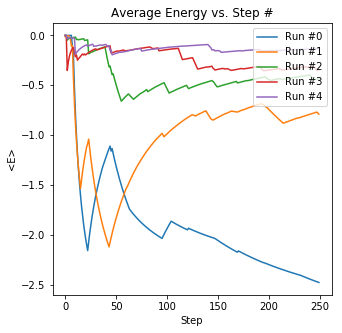

[]

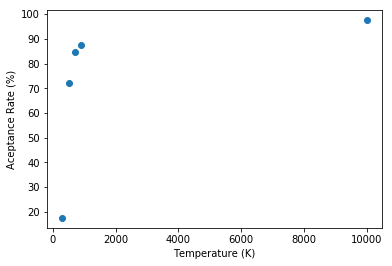

In [10]:
N=20


Nsteps=200                #How many steps to take.
exchange_checkpoint=20    #Number of steps between exchange attempts
#Note that the actual number of "frames" will be Nsteps+math.floor(Nstep/exchange_checkpoint) becasue each echange attapt is saved as a step.

#Get the inital eoordinates and energy. each replica in the replica exchange is started from the same point.
coords=get_N_particles(N,parameters,dims=dims)   #Builds a box of N particles in dims dimentions by adding one particle to the box at a time.
V=get_potentialN(coords, parameters)             #Get the potential of the inital coordinates.


#Ts=[300,325,350,375,400]            #Temperature that will be used for each replica. To only run one simulation make this list length one.

#Create a dictionary to store the acceptance rate of exchange attempts.
pairs = list(itertools.combinations(range(len(Ts)), 2))     #Create a list of all pairs of replicas.
exchange_acceptance={}
#Iterate over all pairs of replicas to make them keys inside a dictionary.
for i in range(len(pairs)):
  exchange_acceptance['%s_%s' %(str(pairs[i][0]), str(pairs[i][1]))]=[]

#Dictionaries to store coordinates, energies, and acceptance of MC steps.
#Note this acceptance does not include exchange attempts.
all_coords_all_runs={}
all_energies_all_runs={}
acceptance={}
for i in range(len(Ts)):                  #initialize the keys for each dictionary
  all_coords_all_runs['run%s' %str(i)]=[]
  all_energies_all_runs['run%s' %str(i)]=[]
  acceptance['run%s' %str(i)]=[]

for k in range(Nsteps):
  for j in range(len(Ts)):
    if k>0:
      #resets the variables "coords" and "V" after each exchange attempt. 
      #This is just for book keeping and no calculations are done in this if statement.
      coords=all_coords_all_runs['run%s' %str(j)][-1]
      V=all_energies_all_runs['run%s' %str(j)][-1]
    
    coords, V, accept = take_mc_step(coords,V,parameters,particles_to_move=0,T=Ts[j],kb=1.9872e-3)  #Takes a monte carlo step. If particles_to_move==0 then all particles are moved.
    all_coords_all_runs['run%s' %str(j)].append(coords)           #List of coordinates
    all_energies_all_runs['run%s' %str(j)].append(V)              #List of energies
    acceptance['run%s' %str(j)].append(accept)                    #list of accept/reject (1 or 0)
    if (k+1)%exchange_checkpoint==0:    #An exchange attempt is made every exchange_checkpoint number of steps
      energies_last=[]      #List to hold most recent energies from each replica
      coords_last=[]        #List to hold  most recent coordinates from each replica
      for run in range(len(Ts)): 
        energies_last.append(all_energies_all_runs['run%s' %str(run)][-1])
        coords_last.append(all_coords_all_runs['run%s' %str(run)][-1])
      
      energies_ex, coords_ex, pair_ex = do_MC_exchange(energies_last,coords_last,Ts)  #Attempt replica exchananges.

      for run in range(len(Ts)):  #Add the energies and coordinates after the exchange attempt to the end of the list for each run.
        all_coords_all_runs['run%s' %str(run)].append(coords_ex[run])
        all_energies_all_runs['run%s' %str(run)].append(energies_ex[run])
      for pair in range(len(pairs)):    #Keep track of which exchanges were accepted and rejected. Any exchange that was not attempted counts as a reject.
        exchange_acceptance['%s_%s' %(str(pairs[pair][0]), str(pairs[pair][1]))].append(pair_ex[pair])
                

#Calculate and print acceptance rate for each run.
acceptance_rate={}
for i in range(len(Ts)):
  acceptance_rate['run%s' %str(i)]=np.mean(np.array(acceptance['run%s' %str(i)]))*100
  print('Run',i,'acceptance rate:', acceptance_rate['run%s' %str(i)])

#Calculate and print acceptance rate of exchange between each pair of replicas
exchange_acceptance_rates={}
for pair in range(len(pairs)):
  exchange_acceptance_rates['%s_%s' %(str(pairs[pair][0]), str(pairs[pair][1]))]=np.mean(np.array(exchange_acceptance['%s_%s' %(str(pairs[pair][0]), str(pairs[pair][1]))]))*100
  print('Pair', pairs[pair], 'exchange_rate:', exchange_acceptance_rates['%s_%s' %(str(pairs[pair][0]), str(pairs[pair][1]))])


#Calculate the running mean for the energies of each run
running_mean_all={}
for i in range(len(Ts)):
  running_mean_all['run%s' %str(i)]=running_mean(all_energies_all_runs['run%s' %str(i)])


#Plot the running mean of the energies for each run.
plt.figure(figsize=[5,5])
for i in range(len(Ts)):
  plt.plot(range(len(running_mean_all['run%s' %str(i)])),running_mean_all['run%s' %str(i)],label='Run #%s' %str(i))
plt.legend(loc=1)
plt.title('Average Energy vs. Step #')
plt.ylabel('<E>')
plt.xlabel('Step')
plt.show()


#Plot the acceptance rate as a function of Temperature.
#This does not mean much when replica exchange is allowed but you can set exchange_checkpoint to be greater than Nstep to turn off exchanges
ac=[]
for i in range(len(Ts)):
    ac.append(acceptance_rate['run%s' %str(i)])
plt.scatter(Ts,ac)
plt.xlabel('Temperature (K)')
plt.ylabel('Aceptance Rate (%)')
plt.plot()



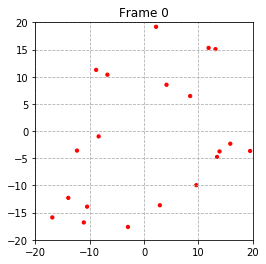

MovieWriter ffmpeg unavailable. Trying to use pillow instead.
c:\users\cdeve\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [7]:
#Makes a gif from one replica in a REMC simulation. This only works for 2 dimentions
#Note this does not work in google colab. I tested this on my labtop and it works though.

frames=len(all_coords_all_runs['run0'])       #How many frames in the gif
replica='0'
fig, ax = plt.subplots()    #Initialize the plot
ax.set_aspect(1)

def animate(i):
  ax.clear()                  #clears the plot each time so the previous cicles disapear
  #reset bounds after clearing plot
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  ax.grid(linestyle='--')
  ax.set_title('Frame ' + str(i))
  #This makes a circle for each particle with radius sigma.
  for j in range(len(all_coords_all_runs['run'+replica][0])):
    circle = plt.Circle((all_coords_all_runs['run'+replica][i][j][0], all_coords_all_runs['run'+replica][i][j][1]), parameters['sigma'], color='r')
    ax.add_artist(circle)
  return ax

ani = FuncAnimation(fig, animate, repeat=False, interval=200,frames=frames)
plt.show()
ani.save('One_run_REMC.gif')

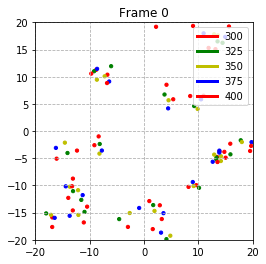

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


In [8]:
#Makes a gif from all replicas in a REMC simulation. This only works for 2 dimentions
#Note this does not work in google colab. I tested this on my labtop and it works though.

frames=len(all_coords_all_runs['run0'])

fig, ax = plt.subplots()
ax.set_aspect(1)
color=['r', 'g', 'y', 'b', 'r']    #color for each replica
def animate(i):
  labels=[]
  custom_lines=[]
  ax.clear()
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  ax.grid(linestyle='--')
  ax.set_title('Frame ' + str(i))
  for k in range(len(Ts)):
    for j in range(len(all_coords_all_runs['run%s' %str(k)][0])):
      #This makes a circle for each particle with radius sigma.
      circle = plt.Circle((all_coords_all_runs['run%s' %str(k)][i][j][0], all_coords_all_runs['run%s' %str(k)][i][j][1]), parameters['sigma'], color=color[k])
      ax.add_artist(circle)
    custom_lines.append(Line2D([0], [0], color=color[k], lw=3))
    labels.append(str(Ts[k]))
  ax.legend(custom_lines, labels)
  return ax

ani = FuncAnimation(fig, animate, repeat=False, interval=200,frames=frames)
plt.show()
ani.save('All_runs_REMC.gif')